<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Модель</a></span></li>

# Восстановление золота из руды

Подготовим прототип модели машинного обучения. Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Для этого используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


## Подготовка данных

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [3]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_all = pd.read_csv('/datasets/gold_recovery_full_new.csv')

Целевые признаки на которых сосредоточим нашу работу:

rougher.output.recovery - эффективность обогащения чернового концентрата 

final.output.recovery - эффективность обогащения финального концентрата

Rougher feed — исходное сырье
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
Xanthate **— ксантогенат (промотер, или активатор флотации);
Sulphate — сульфат (на данном производстве сульфид натрия);
Depressant — депрессант (силикат натрия).
Rougher process (англ. «грубый процесс») — флотация
Rougher tails — отвальные хвосты
Float banks — флотационная установка
Cleaner process — очистка
Rougher Au — черновой концентрат золота
Final Au — финальный концентрат золота

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между расчётами и значением признака:

Эффективность расчитаем по формуле:
R = (С*(F-T))/(F*(C-T)) *100, где
C — доля золота в концентрате после флотации/очистки;
F — доля золота в сырье/концентрате до флотации/очистки;
T — доля золота в отвальных хвостах после флотации/очистки.

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant             

In [5]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']

In [6]:
data_train['new'] = ((C*(F-T))/(F*(C-T)))*100

In [7]:
data_train[['new','rougher.output.recovery']].head()

,new,rougher.output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [8]:
mean_absolute_error(data_train['new'], data_train['rougher.output.recovery'])

9.682896147825551e-15

По полученному значению среднего абсолютного отклонения между полученными данными вручную и имеющимися, можно сделать вывод что представленные нам данные корректны.

In [9]:
data_train = data_train.drop('new', axis=1)

In [10]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
date                                          5290 non-null object
primary_cleaner.input.sulfate                 5286 non-null float64
primary_cleaner.input.depressant              5285 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5286 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.in

In [11]:
a = data_train.drop(data_test.columns, axis=1)
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 34 columns):
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.output.concentrate_ag                 14149 non-null float64
primary_cleaner.output.concentrate_pb                 14063 non-null float64
primary_cleaner.output.concentrate_sol      

Проанализировав признаки, недоступные в тестовой выборке. Мы видим, что в нее не включены выходные параметры продукта после флотации, первичной, вторичной очистки, данные по конечному(финальному) концентрату, отвальные хвосты по этим же стадиям. Самое главное, что тестовая выборка не содержит целевых признаков, что не даст проверить качество модели на ней. 

In [12]:
data_train.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [13]:
data_train = data_train.dropna(subset=data_train.columns).reset_index(drop=True)

In [14]:
data_train.shape

(11017, 87)

In [15]:
data_train.duplicated().sum()

0

In [16]:
data_test.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

In [17]:
data_test = data_test.dropna(subset=data_test.columns).reset_index(drop=True)

In [18]:
data_test.shape

(5229, 53)

In [19]:
data_train['date'] = pd.to_datetime(data_train['date'], format="%Y-%m-%d %H:%M:%S")
data_test['date'] = pd.to_datetime(data_test['date'], format="%Y-%m-%d %H:%M:%S")
data_all['date'] = pd.to_datetime(data_all['date'], format="%Y-%m-%d %H:%M:%S")

In [20]:
date_train_1 = list(data_train['date'])
date_test_1  = list(data_test['date'])

data_all['sample'] = ''
data_all.loc[data_all['date'].isin(date_train_1) == True, 'sample'] = 'train'
data_all.loc[data_all['date'].isin(date_test_1)  == True, 'sample'] = 'test'

data_all['sample'].value_counts()

train    11017
test      5229
          3193
Name: sample, dtype: int64

In [21]:
set = ['rougher.input.feed_sol','rougher.input.floatbank11_xanthate',
       'secondary_cleaner.state.floatbank2_a_air','secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank3_a_air']

before_len = len(data_all['date'])

for name in set:
    data_all = data_all.loc[(((data_all[name].isnull() == False) & 
                                                  (data_all['sample'] == 'test')) | 
                                                 (data_all['sample'] == 'train'))]

after_len = len(data_all['date'])
print('Удалено строк:',before_len - after_len)

Удалено строк: 3193


In [22]:
data_all = data_all[~(data_all['rougher.output.recovery'].isnull())]
data_all = data_all[~(data_all['final.output.recovery'].isnull())]

In [23]:
data_all = data_all.sort_values(by=['date'])
data_all = data_all.ffill()

## Построим модель

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

In [24]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 87 columns):
date                                                  11017 non-null datetime64[ns]
final.output.concentrate_ag                           11017 non-null float64
final.output.concentrate_pb                           11017 non-null float64
final.output.concentrate_sol                          11017 non-null float64
final.output.concentrate_au                           11017 non-null float64
final.output.recovery                                 11017 non-null float64
final.output.tail_ag                                  11017 non-null float64
final.output.tail_pb                                  11017 non-null float64
final.output.tail_sol                                 11017 non-null float64
final.output.tail_au                                  11017 non-null float64
primary_cleaner.input.sulfate                         11017 non-null float64
primary_cleaner.input.depressant     

In [25]:
data_au=data_train[['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']]
data_au.tail()

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
11012,5.335862,18.603550,32.940215,46.713954
11013,4.838619,18.441436,32.925325,46.866780
11014,4.525061,15.111231,31.856742,46.795691
11015,4.362781,17.834772,30.770892,46.408188
11016,4.365491,17.804134,30.356618,46.299438


Концентрация металла увеличивается в зависимости от стадии очистки.  

In [26]:
data_ag=data_train[['rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']]
data_ag.tail()

,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
11012,6.091855,11.124896,6.559174,3.224920
11013,6.121323,11.425983,6.612376,3.195978
11014,5.970515,8.523497,7.128896,3.109998
11015,6.048130,11.658799,7.490444,3.367241
11016,6.158718,11.959486,7.537584,3.598375


Концентрация серебра на первых этапах возрастает и снижается к финальной очистке. Можно предположить, что часть металла идет с примесью и удаляется.

In [27]:
data_pb=data_train[['rougher.input.feed_pb','rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']]
data_pb.head()

,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
0,2.284912,7.101074,10.389648,9.889648
1,2.266033,7.278807,10.497069,9.968944
2,2.159622,7.216833,10.354494,10.213995
3,2.037807,7.175616,8.496563,9.977019
4,1.786875,7.240205,9.986786,10.142511


После первой стадии очистки концентрация свинца в разы увеличивается, а на последующих практически не изменяется.

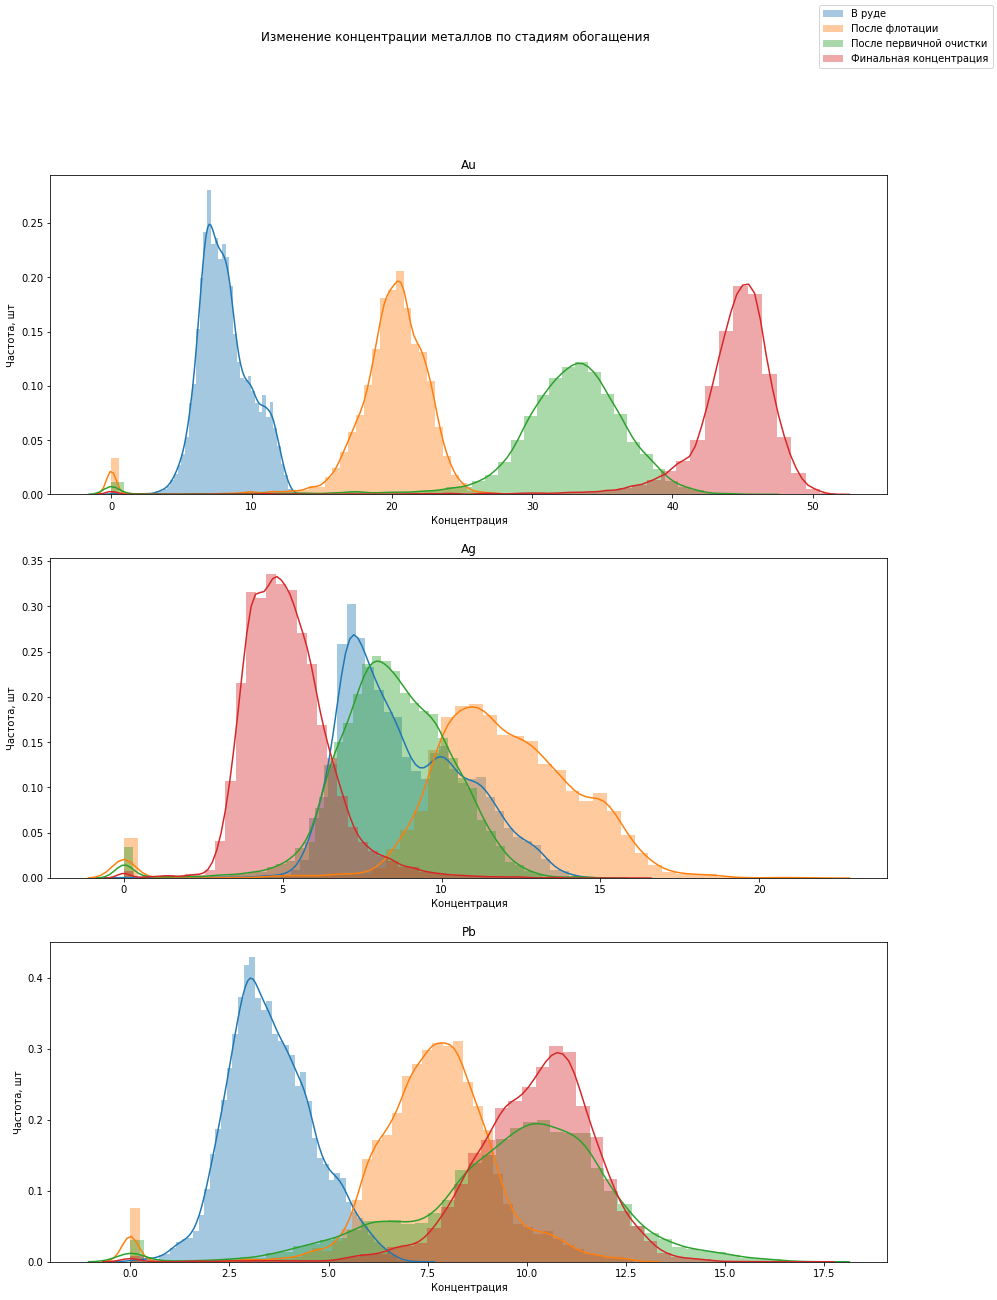

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(15, 20))
for column in list(data_au):
    sns.distplot(data_au[column], ax=axes[0])
axes[0].set(title="Au", xlabel="Концентрация", ylabel="Частота, шт")
for column in list(data_ag):
    sns.distplot(data_ag[column], ax=axes[1])
axes[1].set(title="Ag", xlabel="Концентрация", ylabel="Частота, шт")
for column in list(data_pb):
    sns.distplot(data_pb[column], ax=axes[2])
axes[2].set(title="Pb", xlabel="Концентрация", ylabel="Частота, шт")
fig.suptitle("Изменение концентрации металлов по стадиям обогащения")
fig.legend(["В руде", "После флотации", "После первичной очистки", "Финальная концентрация"])
fig.show()

По графикам видно, что на каждой стадии имеются выбросы (0 - значения), может сказаться на обучении модели.

In [29]:
data_train['rougher.input.feed_size'].head()

0    55.486599
1    57.278666
2    57.510649
3    57.792734
4    56.047189
Name: rougher.input.feed_size, dtype: float64

In [30]:
data_train['primary_cleaner.input.feed_size'].head()

0    7.25
1    7.25
2    7.25
3    7.25
4    7.25
Name: primary_cleaner.input.feed_size, dtype: float64

In [31]:
data_test['rougher.input.feed_size'].head()

0    62.710452
1    61.961163
2    66.903807
3    59.865919
4    63.315324
Name: rougher.input.feed_size, dtype: float64

In [32]:
data_test['primary_cleaner.input.feed_size'].head()

0    8.080000
1    8.080000
2    7.786667
3    7.640000
4    7.530000
Name: primary_cleaner.input.feed_size, dtype: float64

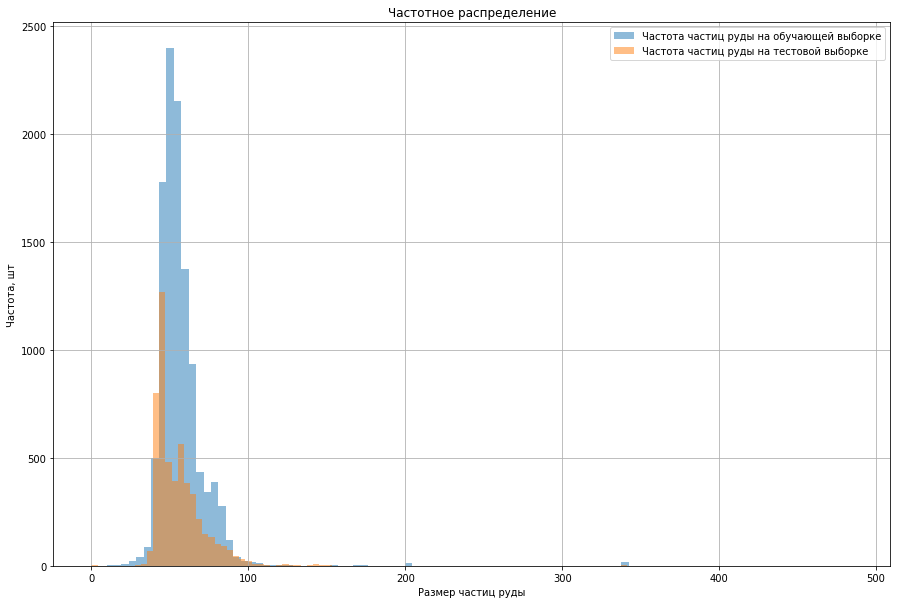

In [33]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(data_train['rougher.input.feed_size'], bins = 100,  alpha=0.5, label='Частота частиц руды на обучающей выборке')
ax.hist(data_test['rougher.input.feed_size'], bins = 100,  alpha=0.5, label='Частота частиц руды на тестовой выборке')
ax.set_title('Частотное распределение')
ax.grid()
ax.legend()
plt.xlabel('Размер частиц руды')
plt.ylabel('Частота, шт')
plt.show()    
    
    

По графику видно, что диапазон колебаний размера частиц в тестовой выборе лежит внутри колебаний на обучающей. Этого достаточно для корректной работы модели.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах:

In [34]:
a['сырье'] = data_train['rougher.input.feed_ag']+data_train['rougher.input.feed_pb']+data_train['rougher.input.feed_sol']+data_train['rougher.input.feed_au']
a['черновой_конц'] = data_train['rougher.output.concentrate_ag']+data_train['rougher.output.concentrate_pb']+data_train['rougher.output.concentrate_sol']+data_train['rougher.output.concentrate_au']
a['очищенный_конц'] = data_train['primary_cleaner.output.concentrate_ag']+data_train['primary_cleaner.output.concentrate_pb']+data_train['primary_cleaner.output.concentrate_sol']+data_train['primary_cleaner.output.concentrate_au']
a['финальный_конц'] = data_train['final.output.concentrate_ag']+data_train['final.output.concentrate_pb']+data_train['final.output.concentrate_sol']+data_train['final.output.concentrate_au']
a=a[['сырье','черновой_конц','очищенный_конц','финальный_конц']]
a.head()

,сырье,черновой_конц,очищенный_конц,финальный_конц
0,51.680034,66.424950,72.640924,63.644396
1,50.659114,67.012710,72.543485,63.957723
2,50.609929,66.103793,72.095042,64.311180
3,51.061546,65.752751,59.957723,63.573449
4,47.859163,65.908382,71.321010,64.004667


In [35]:
a=a.dropna(subset=['сырье','черновой_конц','очищенный_конц','финальный_конц'])

In [36]:
a.isna().sum()

сырье             0
черновой_конц     0
очищенный_конц    0
финальный_конц    0
dtype: int64

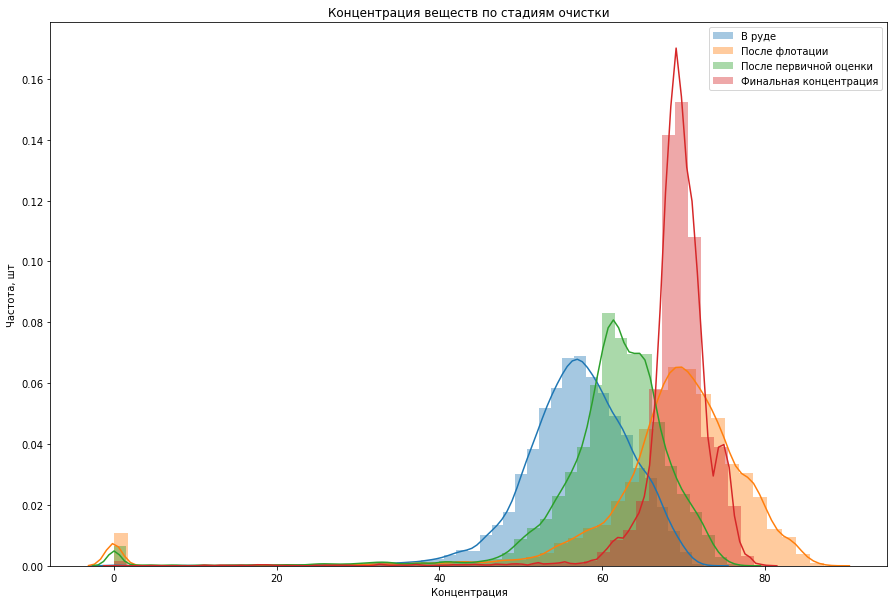

In [37]:
fig = plt.figure(figsize=(15, 10))
column_c = ['сырье', 'черновой_конц', 'очищенный_конц', 'финальный_конц']
column_c2 = ['В руде', 'После флотации', 'После первичной оценки', 'Финальная концентрация']
for column in list(column_c):
    sns.distplot(a[column])
plt.legend(list(column_c2))
plt.title("Концентрация веществ по стадиям очистки")
plt.xlabel("Концентрация")
plt.ylabel("Частота, шт")
fig.show()

Вывод: Общая концентрация всех веществ меняется неравномерно: при флотации растет, затем снижается, а потом снова растет. На последнем этапе значительно снижается разброс, то есть происходит дополнительная стабилизация процесса

In [38]:
a[a['сырье'] <= 0]['сырье'].count()

0

In [39]:
a[a['черновой_конц'] <= 0]['черновой_конц'].count()

205

In [40]:
ind=a[a['черновой_конц'] <= 0]['черновой_конц'].index

In [41]:
ind

Int64Index([  45,   46,   47,   48,  624, 1066, 1406, 1419, 1420, 1421,
            ...
            8865, 8866, 8867, 8868, 8869, 8870, 8871, 8872, 8882, 8883],
           dtype='int64', length=205)

In [42]:
a = a.drop(index=ind)

In [43]:
a[a['черновой_конц'] <= 0]['черновой_конц'].count()

0

In [44]:
ind=a[a['очищенный_конц'] <= 0]['очищенный_конц'].index

In [45]:
a = a.drop(index=ind)

In [46]:
a[a['очищенный_конц'] <= 0]['очищенный_конц'].count()

0

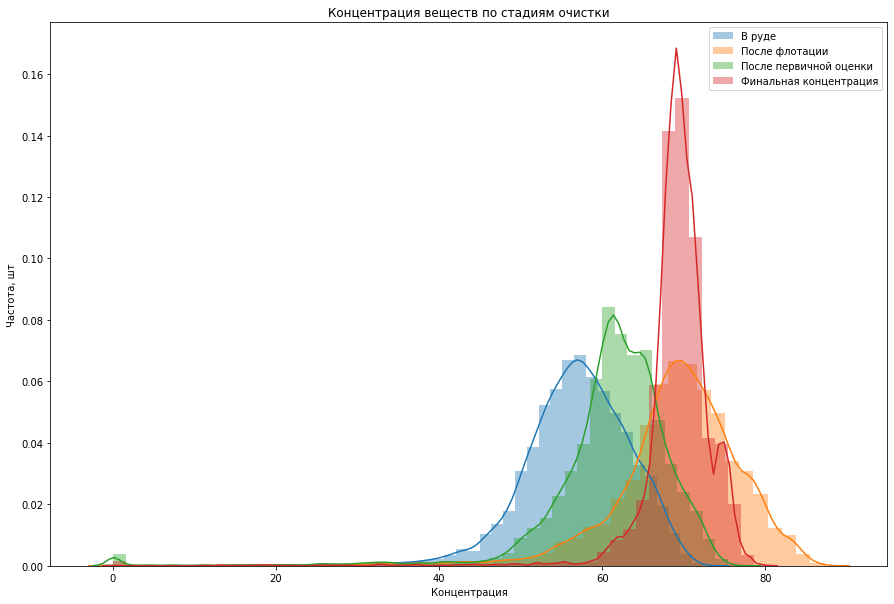

In [47]:
fig = plt.figure(figsize=(15, 10))
column_c = ['сырье', 'черновой_конц', 'очищенный_конц', 'финальный_конц']
column_c2 = ['В руде', 'После флотации', 'После первичной оценки', 'Финальная концентрация']
for column in list(column_c):
    sns.distplot(a[column])
plt.legend(list(column_c2))
plt.title("Концентрация веществ по стадиям очистки")
plt.xlabel("Концентрация")
plt.ylabel("Частота, шт")
fig.show()

Мини вывод по замечанию:

После небольшого анализа видно, что в сырье отутствуют 0 значения и по сути данные можно считать коректными, ведь в сам технологический процесс мы не углубляемся и не знаем как ведут себя концентраты на разных стадиях и что может привести к 0 значениям ( не только системные ошибки). Поэтому я все же настаиваю на том, чтобы эти данные тоже внесли свой вклад в обучении моделей.

Подготовим выборки для моделей:

In [48]:
drop_col = [
    'date', 
    'final.output.concentrate_ag',
    'final.output.concentrate_pb',
    'final.output.concentrate_sol',
    'final.output.concentrate_au',
    'final.output.tail_ag',
    'final.output.tail_pb',
    'final.output.tail_sol',
    'final.output.tail_au',
    'primary_cleaner.output.concentrate_ag',
    'primary_cleaner.output.concentrate_pb',
    'primary_cleaner.output.concentrate_sol',
    'primary_cleaner.output.concentrate_au',
    'primary_cleaner.output.tail_ag',
    'primary_cleaner.output.tail_pb',
    'primary_cleaner.output.tail_sol',
    'primary_cleaner.output.tail_au',
    'rougher.calculation.sulfate_to_au_concentrate',
    'rougher.calculation.floatbank10_sulfate_to_au_feed',
    'rougher.calculation.floatbank11_sulfate_to_au_feed',
    'rougher.calculation.au_pb_ratio',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol',
    'rougher.output.concentrate_au',
    'rougher.output.tail_ag',
    'rougher.output.tail_pb',
    'rougher.output.tail_sol',
    'rougher.output.tail_au',
    'secondary_cleaner.output.tail_ag',
    'secondary_cleaner.output.tail_pb',
    'secondary_cleaner.output.tail_sol',
    'secondary_cleaner.output.tail_au']

In [49]:
data_train = data_train.drop(drop_col, axis=1)

In [50]:
data_train.shape

(11017, 54)

In [51]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 54 columns):
final.output.recovery                         11017 non-null float64
primary_cleaner.input.sulfate                 11017 non-null float64
primary_cleaner.input.depressant              11017 non-null float64
primary_cleaner.input.feed_size               11017 non-null float64
primary_cleaner.input.xanthate                11017 non-null float64
primary_cleaner.state.floatbank8_a_air        11017 non-null float64
primary_cleaner.state.floatbank8_a_level      11017 non-null float64
primary_cleaner.state.floatbank8_b_air        11017 non-null float64
primary_cleaner.state.floatbank8_b_level      11017 non-null float64
primary_cleaner.state.floatbank8_c_air        11017 non-null float64
primary_cleaner.state.floatbank8_c_level      11017 non-null float64
primary_cleaner.state.floatbank8_d_air        11017 non-null float64
primary_cleaner.state.floatbank8_d_level      11017 non-null fl

Разделим выборку под финальный признак:

In [52]:
target_fin = data_train['final.output.recovery']
features_fin = data_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
features_train_fin, features_valid_fin, target_train_fin, target_valid_fin = train_test_split(features_fin, target_fin, test_size = 0.25, random_state =12345)

In [53]:
features_fin.shape

(11017, 52)

In [54]:
rougher = ['rougher.input.feed_ag',
             'rougher.input.feed_pb',             
             'rougher.input.feed_rate',                 
             'rougher.input.feed_size',                       
             'rougher.input.feed_sol',                      
             'rougher.input.feed_au',                        
             'rougher.input.floatbank10_sulfate',             
             'rougher.input.floatbank10_xanthate',            
             'rougher.input.floatbank11_sulfate',  
             'rougher.input.floatbank11_xanthate',                         
             'rougher.state.floatbank10_a_air',         
             'rougher.state.floatbank10_a_level',        
             'rougher.state.floatbank10_b_air',            
             'rougher.state.floatbank10_b_level',         
             'rougher.state.floatbank10_c_air',         
             'rougher.state.floatbank10_c_level',
             'rougher.state.floatbank10_d_air',     
             'rougher.state.floatbank10_d_level',   
             'rougher.state.floatbank10_e_air',       
             'rougher.state.floatbank10_e_level',        
             'rougher.state.floatbank10_f_air',        
             'rougher.state.floatbank10_f_level']

Выборка для прогноза чернового концентрата:

In [55]:
target_rou = data_train['rougher.output.recovery']
features_rou = data_train[rougher]
features_train_rou, features_valid_rou, target_train_rou, target_valid_rou = train_test_split(features_rou, target_rou, test_size = 0.25, random_state =12345)

In [56]:
data_test=data_test.drop(['date'], axis=1)
test_rou = data_test[rougher]

In [57]:
data_test.shape

(5229, 52)

Построим модели:

In [58]:
def smape(y, y_hat):
    num = np.abs(y - y_hat)
    den = (np.abs(y) + np.abs(y_hat)) / 2
    smape = np.mean(num / den) * 100

    return smape

In [59]:
def final_smape(y_rougher, y_hat_rougher, y_final, y_hat_final):
    rougher_num = np.abs(y_rougher - y_hat_rougher)
    rougher_den = (np.abs(y_rougher) + np.abs(y_hat_rougher)) / 2
    smape_rougher = np.mean(rougher_num / rougher_den) * 100

    final_num = np.abs(y_final - y_hat_final)
    final_den = (np.abs(y_final) + np.abs(y_hat_final)) / 2
    smape_final = np.mean(final_num / final_den) * 100

    final_smape = smape_rougher * 0.25 + smape_final * 0.75
    return final_smape

In [60]:
from sklearn import metrics 
smape_scorer = metrics.make_scorer(smape, greater_is_better=False)

Модели флотации:

In [61]:
from sklearn.model_selection import cross_val_score
model_lin = LinearRegression()
model_lin.fit(features_train_rou, target_train_rou)
scores=cross_val_score(model_lin, features_rou, target_rou, cv=5,scoring=smape_scorer)  
print('Флотация, линейная регрессия, sMAPE = ', scores.mean()*-1)

Флотация, линейная регрессия, sMAPE =  9.803981186912967


In [62]:
from sklearn.tree import DecisionTreeRegressor
model_DR = DecisionTreeRegressor(random_state=12345, max_depth=6)
model_DR.fit(features_train_rou, target_train_rou)
scores=cross_val_score(model_DR, features_rou, target_rou, cv=5,scoring=smape_scorer)  
print('Флотация, дерево решений, sMAPE = ', scores.mean()*-1)

Флотация, дерево решений, sMAPE =  12.101317775258494


In [63]:
from sklearn.ensemble import RandomForestRegressor
model_RR = RandomForestRegressor(random_state=12345, n_estimators=30, max_depth=7)
model_RR.fit(features_train_rou, target_train_rou)
scores=cross_val_score(model_RR, features_rou, target_rou, cv=5,scoring=smape_scorer)  
print('Флотация, случайный лес решений, sMAPE = ', scores.mean()*-1)

Флотация, случайный лес решений, sMAPE =  10.775389927350455


In [64]:
pred_tr_rou = model_lin.predict(features_valid_rou)
pred_test_rou = model_lin.predict(test_rou)
print('Флотация, лучшая модель(линейная регрессия), sMAPE:', smape(target_valid_rou,pred_tr_rou))

Флотация, лучшая модель(линейная регрессия), sMAPE: 9.044280924399665


Финальные модели:

In [65]:
model_lf = LinearRegression()
model_lf.fit(features_train_fin, target_train_fin)
scores=cross_val_score(model_lf, features_fin, target_fin, cv=5,scoring=smape_scorer)  
print('Финальная очистка, линейная регрессия, sMAPE = ', scores.mean()*-1)

Финальная очистка, линейная регрессия, sMAPE =  9.746081106190147


In [66]:
model_DRf = DecisionTreeRegressor(random_state=12345, max_depth=3)
model_DRf.fit(features_train_fin, target_train_fin)
scores=cross_val_score(model_DRf, features_fin, target_fin, cv=5,scoring=smape_scorer)  
print('Финальная очистка, дерево решений, sMAPE = ', scores.mean()*-1)

Финальная очистка, дерево решений, sMAPE =  10.128888175693557


In [67]:
model_RRf = RandomForestRegressor(random_state=12345, n_estimators=30, max_depth=7)
model_RRf.fit(features_train_fin, target_train_fin)
scores=cross_val_score(model_RRf, features_fin, target_fin, cv=5,scoring=smape_scorer)  
print('Финальная очистка, случайный лес решений, sMAPE = ', scores.mean()*-1)

Финальная очистка, случайный лес решений, sMAPE =  10.073000598330102


In [68]:
pred_tr_fin = model_lf.predict(features_valid_fin)
pred_test_fin = model_lf.predict(data_test)
print('Финальная очистка, лучшая модель(ленейная регрессия), sMAPE:', smape(target_valid_fin,pred_tr_fin))

Финальная очистка, лучшая модель(ленейная регрессия), sMAPE: 7.186809221622931


In [69]:
Y1_pred_constant_model_mean_trein_rou = pd.Series(target_train_rou.mean(),   index=target_train_rou.index)
Y2_pred_constant_model_mean_test_trein_fin   = pd.Series(target_train_fin.mean(),   index=target_train_fin.index)
Y1_pred_constant_model_median_test_trein_rou = pd.Series(target_train_rou.median(), index=target_train_rou.index)
Y2_pred_constant_model_median_test__trein_fin = pd.Series(target_train_fin.median(), index=target_train_fin.index)

print('Тест,  по среднему, final sMAPE = ', final_smape(target_train_rou, Y1_pred_constant_model_mean_trein_rou,   target_train_fin, Y2_pred_constant_model_mean_test_trein_fin))                               
print('Тест,  по медиане,  final sMAPE = ', final_smape(target_train_rou, Y1_pred_constant_model_median_test_trein_rou, target_train_fin, Y2_pred_constant_model_median_test__trein_fin)) 

Тест,  по среднему, final sMAPE =  9.932252515291045
Тест,  по медиане,  final sMAPE =  9.827209524991614


Сравнивая итоговую метрику для нашей модели с константными по медиане и среднему видно, что показания метрики на нашей модели выше, следовательно наша модель работает и адекватна.

In [70]:
data_all_2 = data_all.drop(drop_col, axis=1)

Поскольку целевые признаки отсутствуют в тестовой выборке, нам придется вытащить их из общей массы информации:

In [71]:
Y1_train = data_all_2.loc[data_all_2['sample'] == 'train', 'rougher.output.recovery']
X1_train = data_all_2.loc[data_all_2['sample'] == 'train', rougher]

Y1_test  = data_all_2.loc[data_all_2['sample'] == 'test', 'rougher.output.recovery']
X1_test  = data_all_2.loc[data_all_2['sample'] == 'test', rougher]

#параметры второго этапа модели
Y2_train = data_all_2.loc[data_all_2['sample'] == 'train', 'final.output.recovery']
X2_train = data_all_2.loc[data_all_2['sample'] == 'train'].drop(['sample', 'final.output.recovery', 'rougher.output.recovery'], axis=1)

Y2_test  = data_all_2.loc[data_all_2['sample'] == 'test', 'final.output.recovery']
X2_test  = data_all_2.loc[data_all_2['sample'] == 'test'].drop(['sample', 'final.output.recovery', 'rougher.output.recovery'], axis=1)

print('Размер обучающей выборки:', len(Y1_train))
print('Размер тестовой выборки:', len(Y1_test))

Размер обучающей выборки: 11017
Размер тестовой выборки: 5229


Проверим лучшие модели на тестовой выборке:

In [72]:
print('Лучшая модель(ленейная регрессия), sMAPE на тестовой выборке для грубой очистки:',smape(Y1_test,pred_test_rou))

Лучшая модель(ленейная регрессия), sMAPE на тестовой выборке для грубой очистки: 9.393031173882163


In [73]:
print('Лучшая модель(ленейная регрессия), sMAPE на тестовой выборке для финальной очистки:',smape(Y2_test,pred_test_fin))

Лучшая модель(ленейная регрессия), sMAPE на тестовой выборке для финальной очистки: 8.770396127007482


In [74]:
print('Тест,  лучшая модель,  final sMAPE = ', final_smape(Y1_test, pred_test_rou, Y2_test, pred_test_fin)) 

Тест,  лучшая модель,  final sMAPE =  8.926054888726153


# Вывод:
Изначальные выборки данных обработаны и подготовлены к построению моделей. Решина проблема отсутствия целевых признаков в тестовой выборке. Одна из выборок разбита на обучающую и тренировочную. Выделено 2 подмассива для расчета каждого из целевых признаков эффективности флотации и обогощения. Построены модели и выбраны лучшие методом кросс валидации для каждого из признаков. Модель линейной регрессии показала себя с лучшей стороны для обоих целевых признаков. Посчитали результат для лучших модели на тестовой выборке. 